<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/EDA_and_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Getting data

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
trn=pd.read_csv('train_transaction.csv.zip')
tst=pd.read_csv('test_transaction.csv.zip')
trn_idn=pd.read_csv('train_identity.csv.zip')
tst_idn=pd.read_csv('test_identity.csv.zip')

In [4]:
trn.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
trn_idn.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
train=trn.merge(trn_idn,on='TransactionID',how='left')
test=tst.merge(tst_idn,on='TransactionID',how='left')

In [7]:
print(train.shape)
print(trn.shape)
print(trn_idn.shape)

(590540, 434)
(590540, 394)
(144233, 41)


In [8]:
import gc
del([trn,tst,trn_idn,tst_idn])
gc.collect()

11

In [9]:
a=list(train.filter(regex='id'))
b=list(test.filter(regex='id'))
dk={}
for i,j in zip(a,b):
  dk[j]=i
test.rename(columns=dk,inplace=True)

Checking nan

In [10]:
ls=list(test)
ln=len(train)
dk={}
for col in ls:
  percent=100*train[col].isna().sum()/ln
  dk[col]=percent
df=pd.DataFrame(dk,index=[1])
df=df.T
df.columns=['nan']
df['columns']=df.index
df=df.reset_index(drop=True)
df

,nan,columns
0,0.000000,TransactionID
1,0.000000,TransactionDT
2,0.000000,TransactionAmt
3,0.000000,ProductCD
4,0.000000,card1
...,...,...
428,76.126088,id_36
429,76.126088,id_37
430,76.126088,id_38
431,76.155722,DeviceType


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


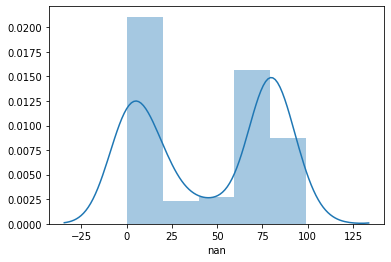

In [11]:
import seaborn as sns
sns.distplot(df['nan'])

Dropping columns with greater than 75 percent nan

In [12]:
dps=df.loc[df['nan']>75]['columns'].values
train=train.drop(dps,1)
test=test.drop(dps,1)
del([df])
gc.collect()

27

In [13]:
print(train.shape)
print(test.shape)
print(len(dps))

(590540, 226)
(506691, 225)
208


Getting an indicator column for each column for nan

In [14]:
ls=list(test)
cat=list(test.select_dtypes(include=object))
for col in ls:
  if train[col].isna().sum()>0:
    train[col+'_isna']=train[col].isna().astype('uint8')
    test[col+'_isna']=test[col].isna().astype('uint8')

Nan distribution across dataframe

In [15]:
ls=list(test)
dk={}
for col in ls:
  dk[col]=train[col].nunique()

df=pd.DataFrame(dk,index=[1])
df=df.T
df.columns=['nunique']
df['columns']=df.index
df=df.reset_index(drop=True)
df

,nunique,columns
0,590540,TransactionID
1,573349,TransactionDT
2,20902,TransactionAmt
3,5,ProductCD
4,13553,card1
...,...,...
426,2,V317_isna
427,2,V318_isna
428,2,V319_isna
429,2,V320_isna


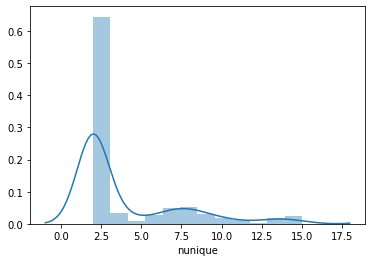

In [16]:
sns.distplot(df['nunique'].loc[df['nunique']<np.percentile(df['nunique'].values,75)])

In [17]:
del([df])
gc.collect()

0

Handling categorical data

In [18]:
train.select_dtypes(include=object).nunique()

ProductCD         5
card4             4
card6             4
P_emaildomain    59
M1                2
M2                2
M3                2
M4                3
M5                2
M6                2
M7                2
M8                2
M9                2
dtype: int64

Seems we can split p_emaildomain into parts before and after '.'

In [19]:
def second(data):
  return data[data.find('.'):]
def first(data):
  return data[:data.find('.')]
train['P_emaildomain'].fillna('nan',inplace=True)
test['P_emaildomain'].fillna('nan',inplace=True)
train['P_emaildomain_first']=train['P_emaildomain'].apply(first)
train['P_emaildomain_second']=train['P_emaildomain'].apply(second)
test['P_emaildomain_first']=test['P_emaildomain'].apply(first)
test['P_emaildomain_second']=test['P_emaildomain'].apply(second)

Since this dataset has imbalance checking if imbalance affects the column values 

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns
def isdff(col):
  fraud=train.loc[train['isFraud']==1]
  n_f=train.loc[train['isFraud']==0].sample(fraud.shape[0])
  df=pd.concat([fraud,n_f],0).reset_index(drop=True)
  num=min(df[col].nunique(),10)
  x=df[col].value_counts().head(num)
  x.plot.bar()
  plt.show()
  y=train[col].value_counts().head(num)
  y.plot.bar()
  ls=list(set(y.index)-set(x.index))
  print(len(ls))
  print(ls)
  list(set(x.index)-set(y.index))
  del([df])
  gc.collect()

In [21]:
categorical = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2",
               "P_emaildomain",'P_emaildomain_first','P_emaildomain_second', "R_emaildomain",
              "DeviceInfo", "DeviceType"] + ["id_0" + str(i) for i in range(1, 10)] +\
                ["id_" + str(i) for i in range(10, 39)] + \
                 ["M" + str(i) for i in range(1, 10)]
categorical=set(categorical).intersection(set(list(test)))
categorical

{'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'P_emaildomain_first',
 'P_emaildomain_second',
 'ProductCD',
 'addr1',
 'addr2',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6'}

Checking Ms

In [22]:
ls=train.filter(regex='M')
for col in ls:
  print(col)
  print(train[col].unique())
  print()

M1
['T' nan 'F']

M2
['T' nan 'F']

M3
['T' nan 'F']

M4
['M2' 'M0' nan 'M1']

M5
['F' 'T' nan]

M6
['T' 'F' nan]

M7
[nan 'F' 'T']

M8
[nan 'F' 'T']

M9
[nan 'F' 'T']

M1_isna
[0 1]

M2_isna
[0 1]

M3_isna
[0 1]

M4_isna
[0 1]

M5_isna
[0 1]

M6_isna
[0 1]

M7_isna
[1 0]

M8_isna
[1 0]

M9_isna
[1 0]



Ms seems like flags lets see if any flag fraud

In [74]:
ln=len(train)
dk={}
for i in range(1,10):
  col='M'+str(i)
  (train.groupby([col])['isFraud'].value_counts(normaliza=True)).plot.barh()
  plt.show()

KeyError: ignored

It seems fradulant transactions trend to avoid these checks so a useful feature could be how many of Ms were nan

In [24]:
train['M_nan']=0
test['M_nan']=0
for i in range(1,10):
  train['M_nan']+=train['M'+str(i)+'_isna']
  test['M_nan']+=test['M'+str(i)+'_isna']

checking cards

There are 195 countries and 25000 banks so card1 should be a bank and card3 or card5 should be country

In [25]:
ls=train.filter(regex='card')
for col in ls:
  print(col)
  print(train[col].nunique())
  print()

card1
13553

card2
500

card3
114

card4
4

card5
119

card6
4

card2_isna
2

card3_isna
2

card4_isna
2

card5_isna
2

card6_isna
2



checking address

In [26]:
ls=train.filter(regex='addr')
for col in ls:
  print(col)
  print(train[col].nunique())
  print()

addr1
332

addr2
74

addr1_isna
2

addr2_isna
2



Getting dummies of top 10 most common categories and label encoding of card1 and id_02 since they have many categories

(590540, 435)
(506691, 434)


  0%|          | 0/21 [00:00<?, ?it/s]

addr2
before 93
before 11


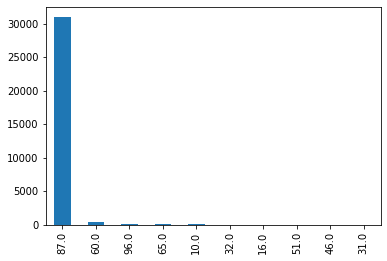

3
[27.0, 26.0, 19.0]


  5%|▍         | 1/21 [00:03<01:14,  3.72s/it]

M1
before 2
before 3


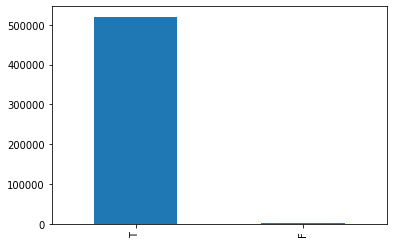

0
[]


 10%|▉         | 2/21 [00:07<01:13,  3.87s/it]

M8
before 2
before 3


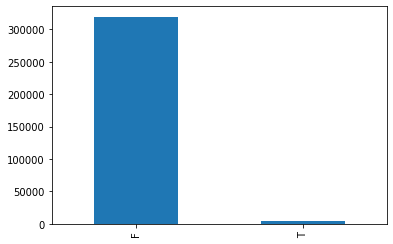

0
[]


 14%|█▍        | 3/21 [00:11<01:07,  3.77s/it]

M9
before 2
before 3


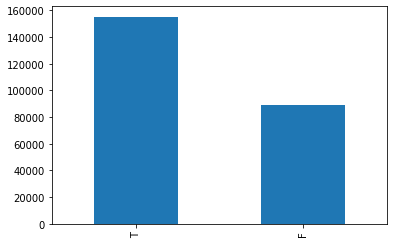

0
[]


 19%|█▉        | 4/21 [00:14<01:02,  3.69s/it]

M7
before 2
before 3


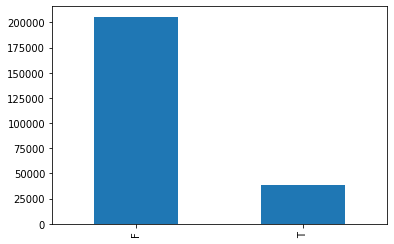

0
[]


 24%|██▍       | 5/21 [00:18<00:58,  3.64s/it]

M6
before 2
before 3


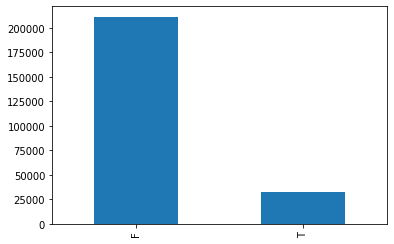

0
[]


 29%|██▊       | 6/21 [00:22<00:54,  3.61s/it]

card4
before 4
before 5


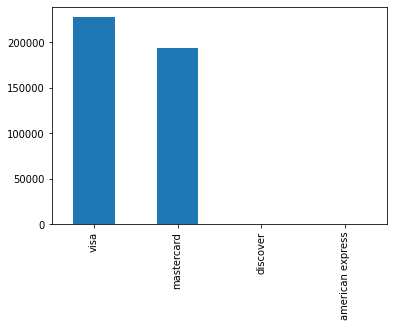

0
[]


 33%|███▎      | 7/21 [00:25<00:50,  3.63s/it]

ProductCD
before 5
before 5


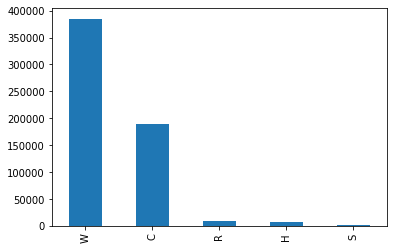

0
[]


 38%|███▊      | 8/21 [00:29<00:46,  3.59s/it]

card6
before 4
before 5


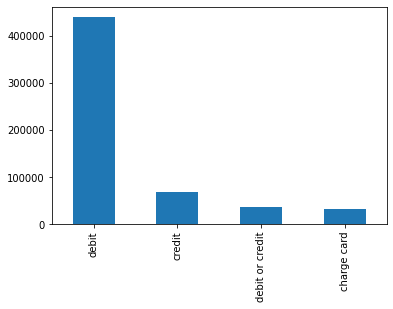

0
[]


 43%|████▎     | 9/21 [00:32<00:43,  3.59s/it]

M3
before 2
before 3


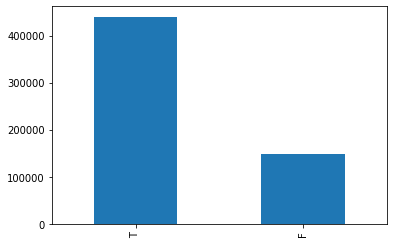

0
[]


 48%|████▊     | 10/21 [00:36<00:39,  3.58s/it]

P_emaildomain
before 61
before 11


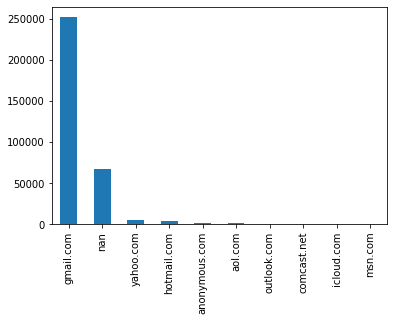

0
[]


 52%|█████▏    | 11/21 [00:40<00:36,  3.62s/it]

M5
before 2
before 3


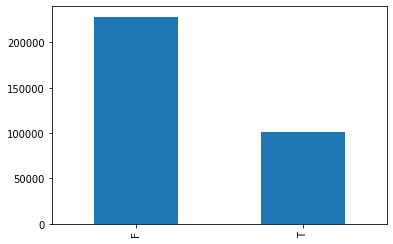

0
[]


 57%|█████▋    | 12/21 [00:43<00:32,  3.61s/it]

card1
before 17091
before 11


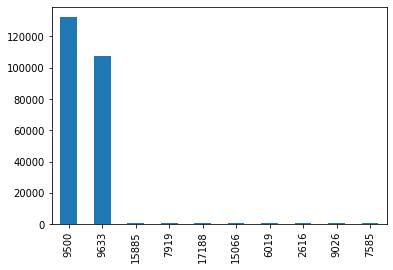

3
[12544, 2803, 12695]


 62%|██████▏   | 13/21 [00:47<00:29,  3.66s/it]

card3
before 133
before 11


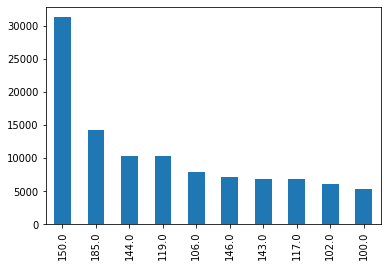

1
[147.0]


 67%|██████▋   | 14/21 [00:51<00:26,  3.85s/it]

addr1
before 441
before 11


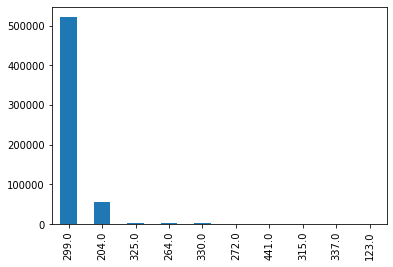

1
[126.0]


 71%|███████▏  | 15/21 [00:56<00:23,  3.98s/it]

P_emaildomain_first
before 47
before 11


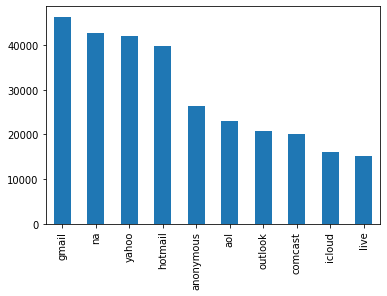

1
['msn']


 76%|███████▌  | 16/21 [00:59<00:19,  3.95s/it]

M2
before 2
before 3


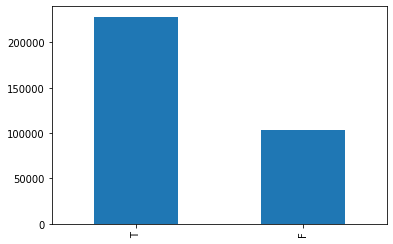

0
[]


 81%|████████  | 17/21 [01:03<00:15,  3.89s/it]

card2
before 501
before 11


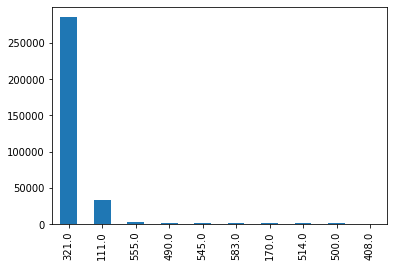

2
[360.0, 194.0]


 86%|████████▌ | 18/21 [01:07<00:12,  4.03s/it]

P_emaildomain_second
before 13
before 11


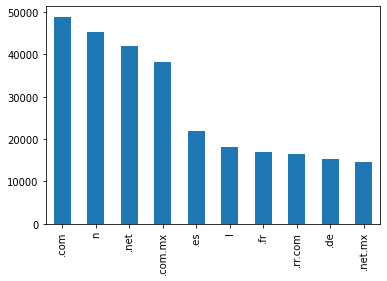

0
[]


 90%|█████████ | 19/21 [01:11<00:07,  3.99s/it]

M4
before 3
before 4


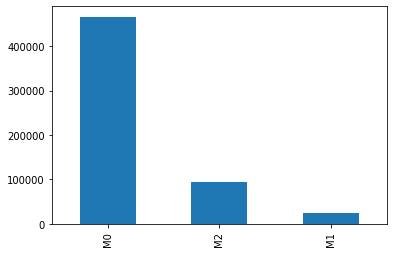

0
[]


 95%|█████████▌| 20/21 [01:15<00:03,  3.95s/it]

card5
before 138
before 11


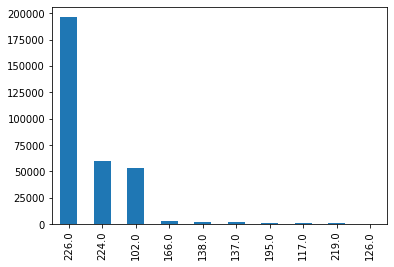

0
[]


100%|██████████| 21/21 [01:20<00:00,  3.82s/it]

(1097231, 577)


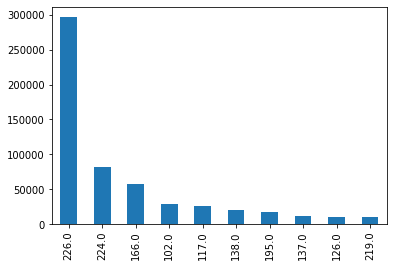

In [27]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
def top_n(categorical,fnl,n):
  cols_name=[]
  for col in tqdm(categorical):
        print(col)
        print('before '+str(fnl[col].nunique()))
        fnl.loc[~fnl[col].isin(list(fnl[col].value_counts().index[:n])),col]='other'
        print('before '+str(fnl[col].nunique()))
        isdff(col)
        if col!='card1' or col !='id_02':
            fnl_dum=pd.get_dummies(fnl[col]).astype('uint8')
            fnl_dum.columns=list(np.char.add(col,np.asarray(list(fnl_dum)).astype(str)))
            fnl_dum.columns=fnl_dum.columns+'_dum'
            cols_name.extend(list(fnl_dum.columns))
            #fnl=fnl.drop([col],1)
            fnl=pd.concat([fnl,fnl_dum],1)
            del([fnl_dum])
            gc.collect()
        else:
          le=LabelEncoder()
          fnl[col]=le.fit_transform(fnl[col]).astype('uint8')
  return fnl,cols_name
print(train.shape)
print(test.shape)
df,new_cols=top_n(categorical,pd.concat([train,test],0).reset_index(drop=True),10)
print(df.shape)

In [28]:
train=df.loc[:590539].reset_index(drop=True)
test=df.loc[590540:].reset_index(drop=True)
print(train.shape)
print(test.shape)
del([df])
gc.collect()

(590540, 577)
(506691, 577)


3103

Convert TransactionDT to day,month,year

In [29]:
def time(df):
  df['day']=df['TransactionDT']//86400
  df['week']=df['TransactionDT']//(86400*7)
  df['month']=df['TransactionDT']//(86400*30)
  return df
train=time(train)
test=time(test)


Lets start with Ds

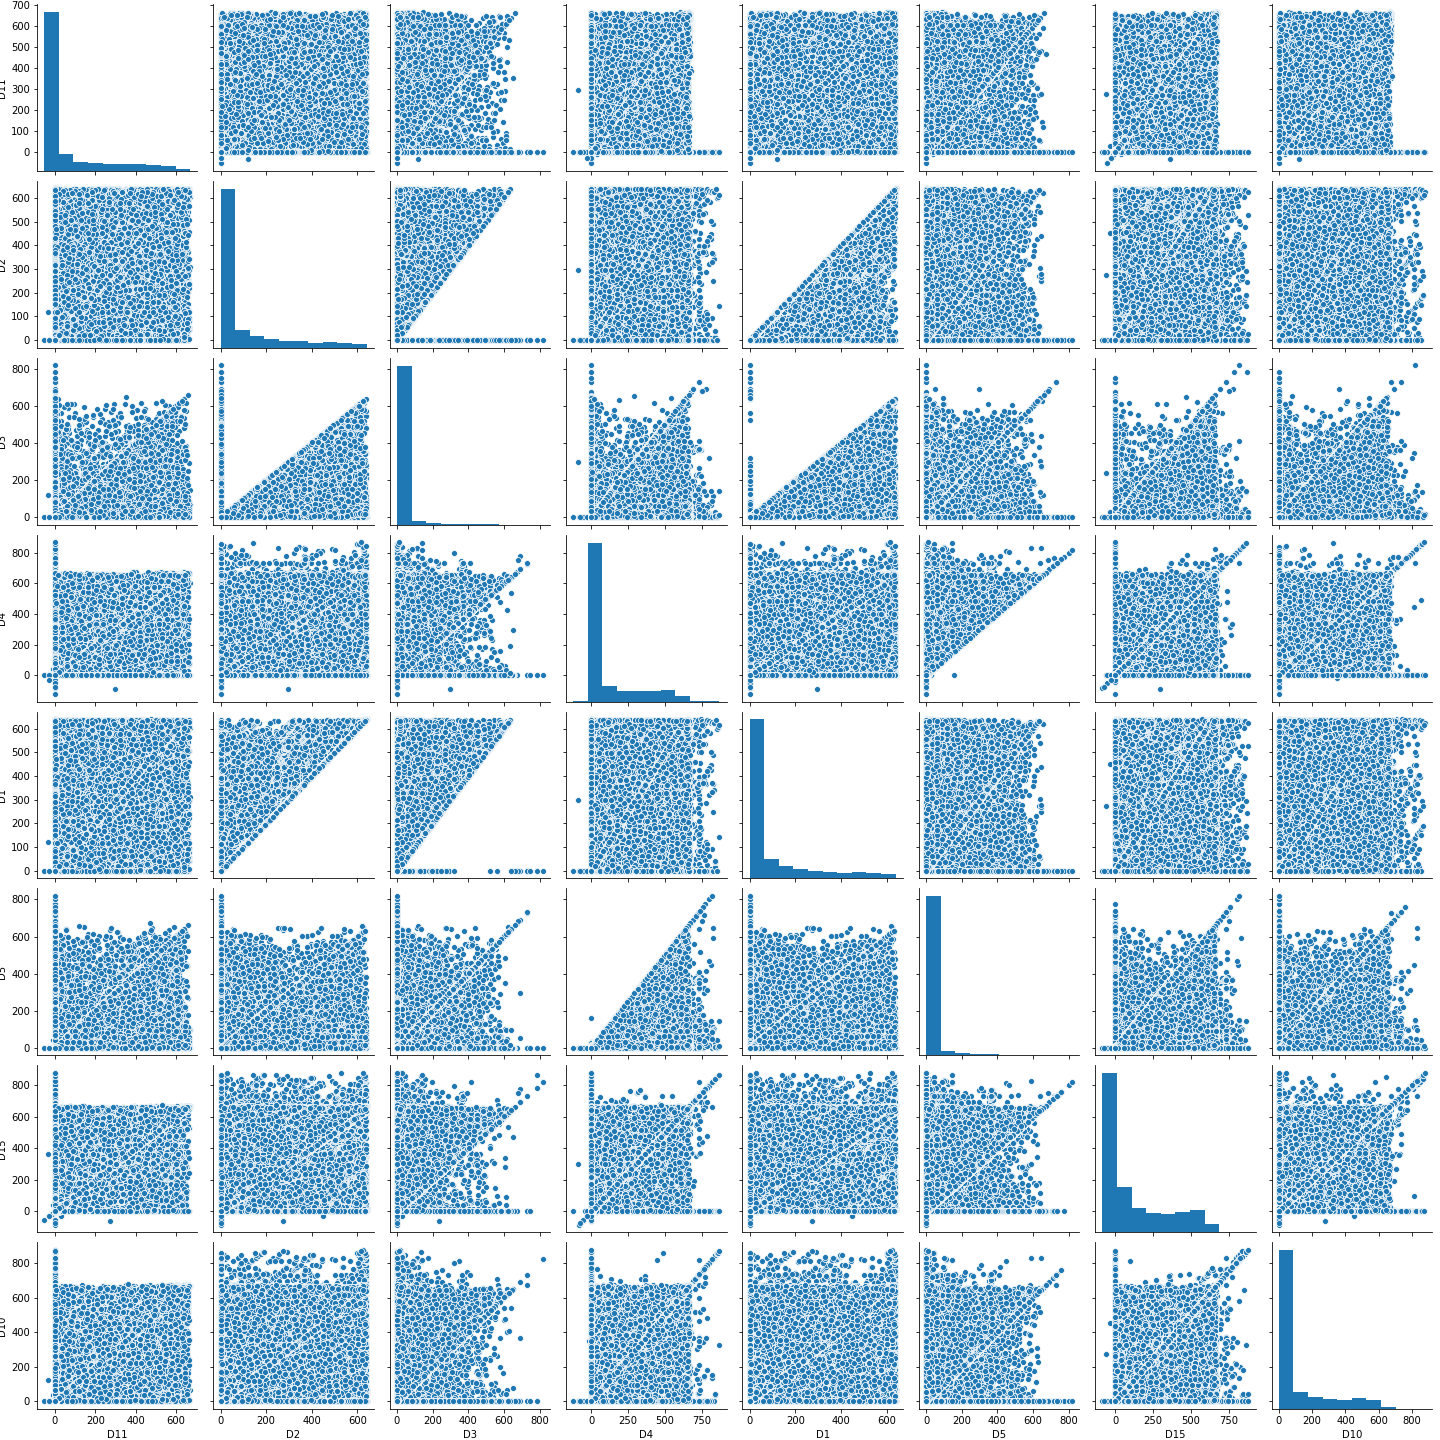

In [30]:
numerical = ["TransactionAmt", "dist1", "dist2","day","week","year"] + ["C" + str(i) for i in range(1, 15)]+["D" + str(i) for i in range(1, 16)]+["V" + str(i) for i in range(1,340)]
numerical=list(set(list(train)).intersection(set(numerical)))
from IPython.core.display import Image
Image( filename ='D_pair_non_nan.png')

An interesting relation is that D2 is always greater than D3 except for D2 == 0

Also D1 is atleast as large as D2 if not more

Also D1 is larger than D3 except for when D1 == 0

Lets focus on these three

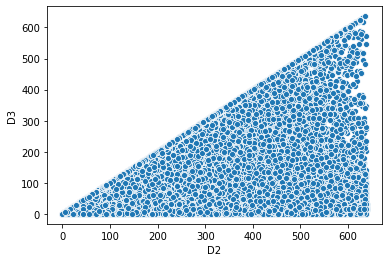

In [31]:
sns.scatterplot(train['D2'],train['D3'])

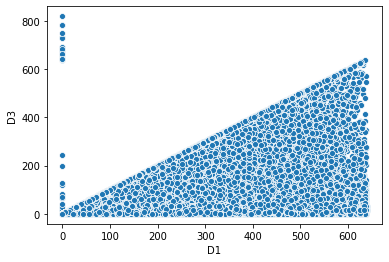

In [32]:
sns.scatterplot(train['D1'],train['D3'])

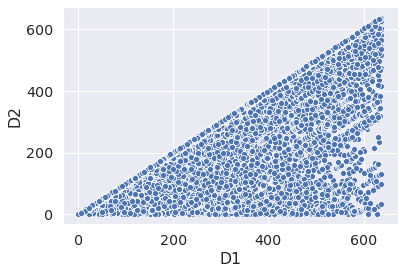

In [33]:
sns.set(font_scale=1.3) 
sns.scatterplot(train['D1'],train['D2'])

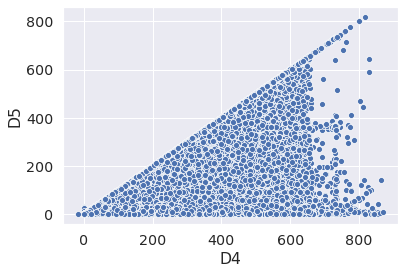

In [34]:

sns.scatterplot(train['D4'],train['D5'])

In [35]:
((set(numerical)-set(train[numerical].filter(regex='V')))-set(train[numerical].filter(regex='C')))-set(train[numerical].filter(regex='D'))

{'TransactionAmt', 'day', 'dist1', 'week'}

In [36]:
categorical

{'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'P_emaildomain_first',
 'P_emaildomain_second',
 'ProductCD',
 'addr1',
 'addr2',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6'}

For referencing an individual lets use addr and card1

In [37]:
train['id']=train['addr1'].astype(str)+train['card1'].astype(str)
test['id']=test['addr1'].astype(str)+test['card1'].astype(str)

I think D1 is the difference in days from date of issue of card and D3 is difference in days from previous transaction,V307 is cumulative of TransactionAmt for each individual.

To prove V307 is cumulative TransactionAmt we make a column new with TransactionAmt+V307 to check with next Transaction of the individual

In [38]:
train['new']=train['TransactionAmt']+train['V307']

In [39]:
train.loc[(train['isFraud']==1)&(train['D1']<train['day'])&(train['D1']!=0)][['D1','D2','D3','id','TransactionAmt','V307','day']].head(20)

,D1,D2,D3,id,TransactionAmt,V307,day
5190,1.0,NaN,0.0,otherother,83.742,83.742104,2
5749,1.0,NaN,0.0,otherother,83.742,58.003700,2
6267,1.0,1.0,1.0,330.09500,200.000,426.000000,2
6269,1.0,1.0,0.0,330.09500,226.000,626.000000,2
8979,1.0,NaN,NaN,otherother,30.633,14.138300,3
9785,1.0,1.0,1.0,otherother,10.634,43.623299,3
9786,1.0,1.0,1.0,otherother,10.634,14.380000,3
9788,1.0,1.0,0.0,otherother,10.634,25.013901,3
9790,1.0,1.0,0.0,otherother,10.634,35.647800,3
10136,1.0,1.0,1.0,otherother,171.000,754.000000,3


Look at the third. Searching for day = 2-1(day-D1) we find one where V307 =0 and TransactionAmt = 83 

In [40]:
train.loc[(train['id']=='330.09500')&(train['day']==1)&(train['new']==426.000000)][['D1','D2','D3','id','TransactionAmt','V307','day']].head(20)

,D1,D2,D3,id,TransactionAmt,V307,day
5081,0.0,0.0,1.0,330.09500,200.0,226.0,1


For the 12 from top

In [41]:
train.loc[(train['id']=='299.0other')&(train['day']==1)&(train['new']==970.000000)][['D1','D2','D3','id','TransactionAmt','V307','day']].head(20)

,D1,D2,D3,id,TransactionAmt,V307,day
4519,0.0,NaN,0.0,299.0other,443.0,527.0,1


In [42]:
train['D3'].values[0] in list(train['D3'].values)

True

Lets see for how many this condition holds true 

In [43]:
from tqdm import tqdm
fr=0
agn=0
for _,row in tqdm(train.loc[train['D3']<train['day']].iterrows()):
  df=train.loc[(train['day']==(row['day']-row['D3']))]
  ls=list(df['new'].values)
  if row['V307'] in ls:
    fr+=1
  else:
    agn+=1

284517it [43:28, 109.06it/s]


In [44]:
print(fr,agn)

111132 173385


Thus D3 is the difference in days from previous transaction and V307 is cumulative TransactionAmt for individual 

Next lets prove D1 is difference in days from issue of card 

To do so i will use 2 facts that


1.   When issuing a card its V307 should be 0 
2.   Or V307 = TransactionAmt



Where D3 is nan it means it was the first transaction or it wasent noted or it is beyound our timeframe  and 0 means transaction was made the same date

In [45]:
#           First transaction      D1 not zero means there is a difference from first transaction              if the difference is within timeframe
train.loc[(train['D3'].isna())&(train['D1']!=0)&(~train['D1'].isna())                                             &(train['D1']<train['day'])]                   [['D1','D2','D3','id','TransactionAmt','V307','day']]

,D1,D2,D3,id,TransactionAmt,V307,day
5148,1.0,1.0,NaN,otherother,25.000,25.0000,2
5411,1.0,NaN,NaN,otherother,100.000,300.0000,2
8979,1.0,NaN,NaN,otherother,30.633,14.1383,3
9437,2.0,2.0,NaN,264.0other,150.000,150.0000,3
10259,2.0,2.0,NaN,272.0other,20.000,15.0000,3
...,...,...,...,...,...,...,...
590056,158.0,158.0,NaN,otherother,150.000,0.0000,182
590061,157.0,157.0,NaN,315.0other,200.000,0.0000,182
590066,157.0,157.0,NaN,315.0other,200.000,200.0000,182
590070,180.0,180.0,NaN,330.0other,14.000,27.0000,182


In [46]:
train.loc[(train['D3'].isna())&(train['D1']==0)][['D1','D2','D3','id','TransactionAmt','V307','day']]

,D1,D2,D3,id,TransactionAmt,V307,day
1,0.0,NaN,NaN,325.0other,29.000,0.0,1
2,0.0,NaN,NaN,330.0other,59.000,0.0,1
4,0.0,NaN,NaN,otherother,50.000,0.0,1
5,0.0,NaN,NaN,272.0other,49.000,0.0,1
6,0.0,NaN,NaN,126.0other,159.000,0.0,1
...,...,...,...,...,...,...,...
590529,0.0,NaN,NaN,otherother,73.838,0.0,182
590530,0.0,NaN,NaN,299.015066,400.780,0.0,182
590534,0.0,NaN,NaN,otherother,67.505,0.0,182
590536,0.0,NaN,NaN,204.0other,39.500,0.0,182


Thus our hypotheses holds mostly

Fill Ds with -999

In [47]:
train[numerical].filter(regex='D').fillna(-999,inplace=True)
test[numerical].filter(regex='D').fillna(-999,inplace=True)

Next is Cs

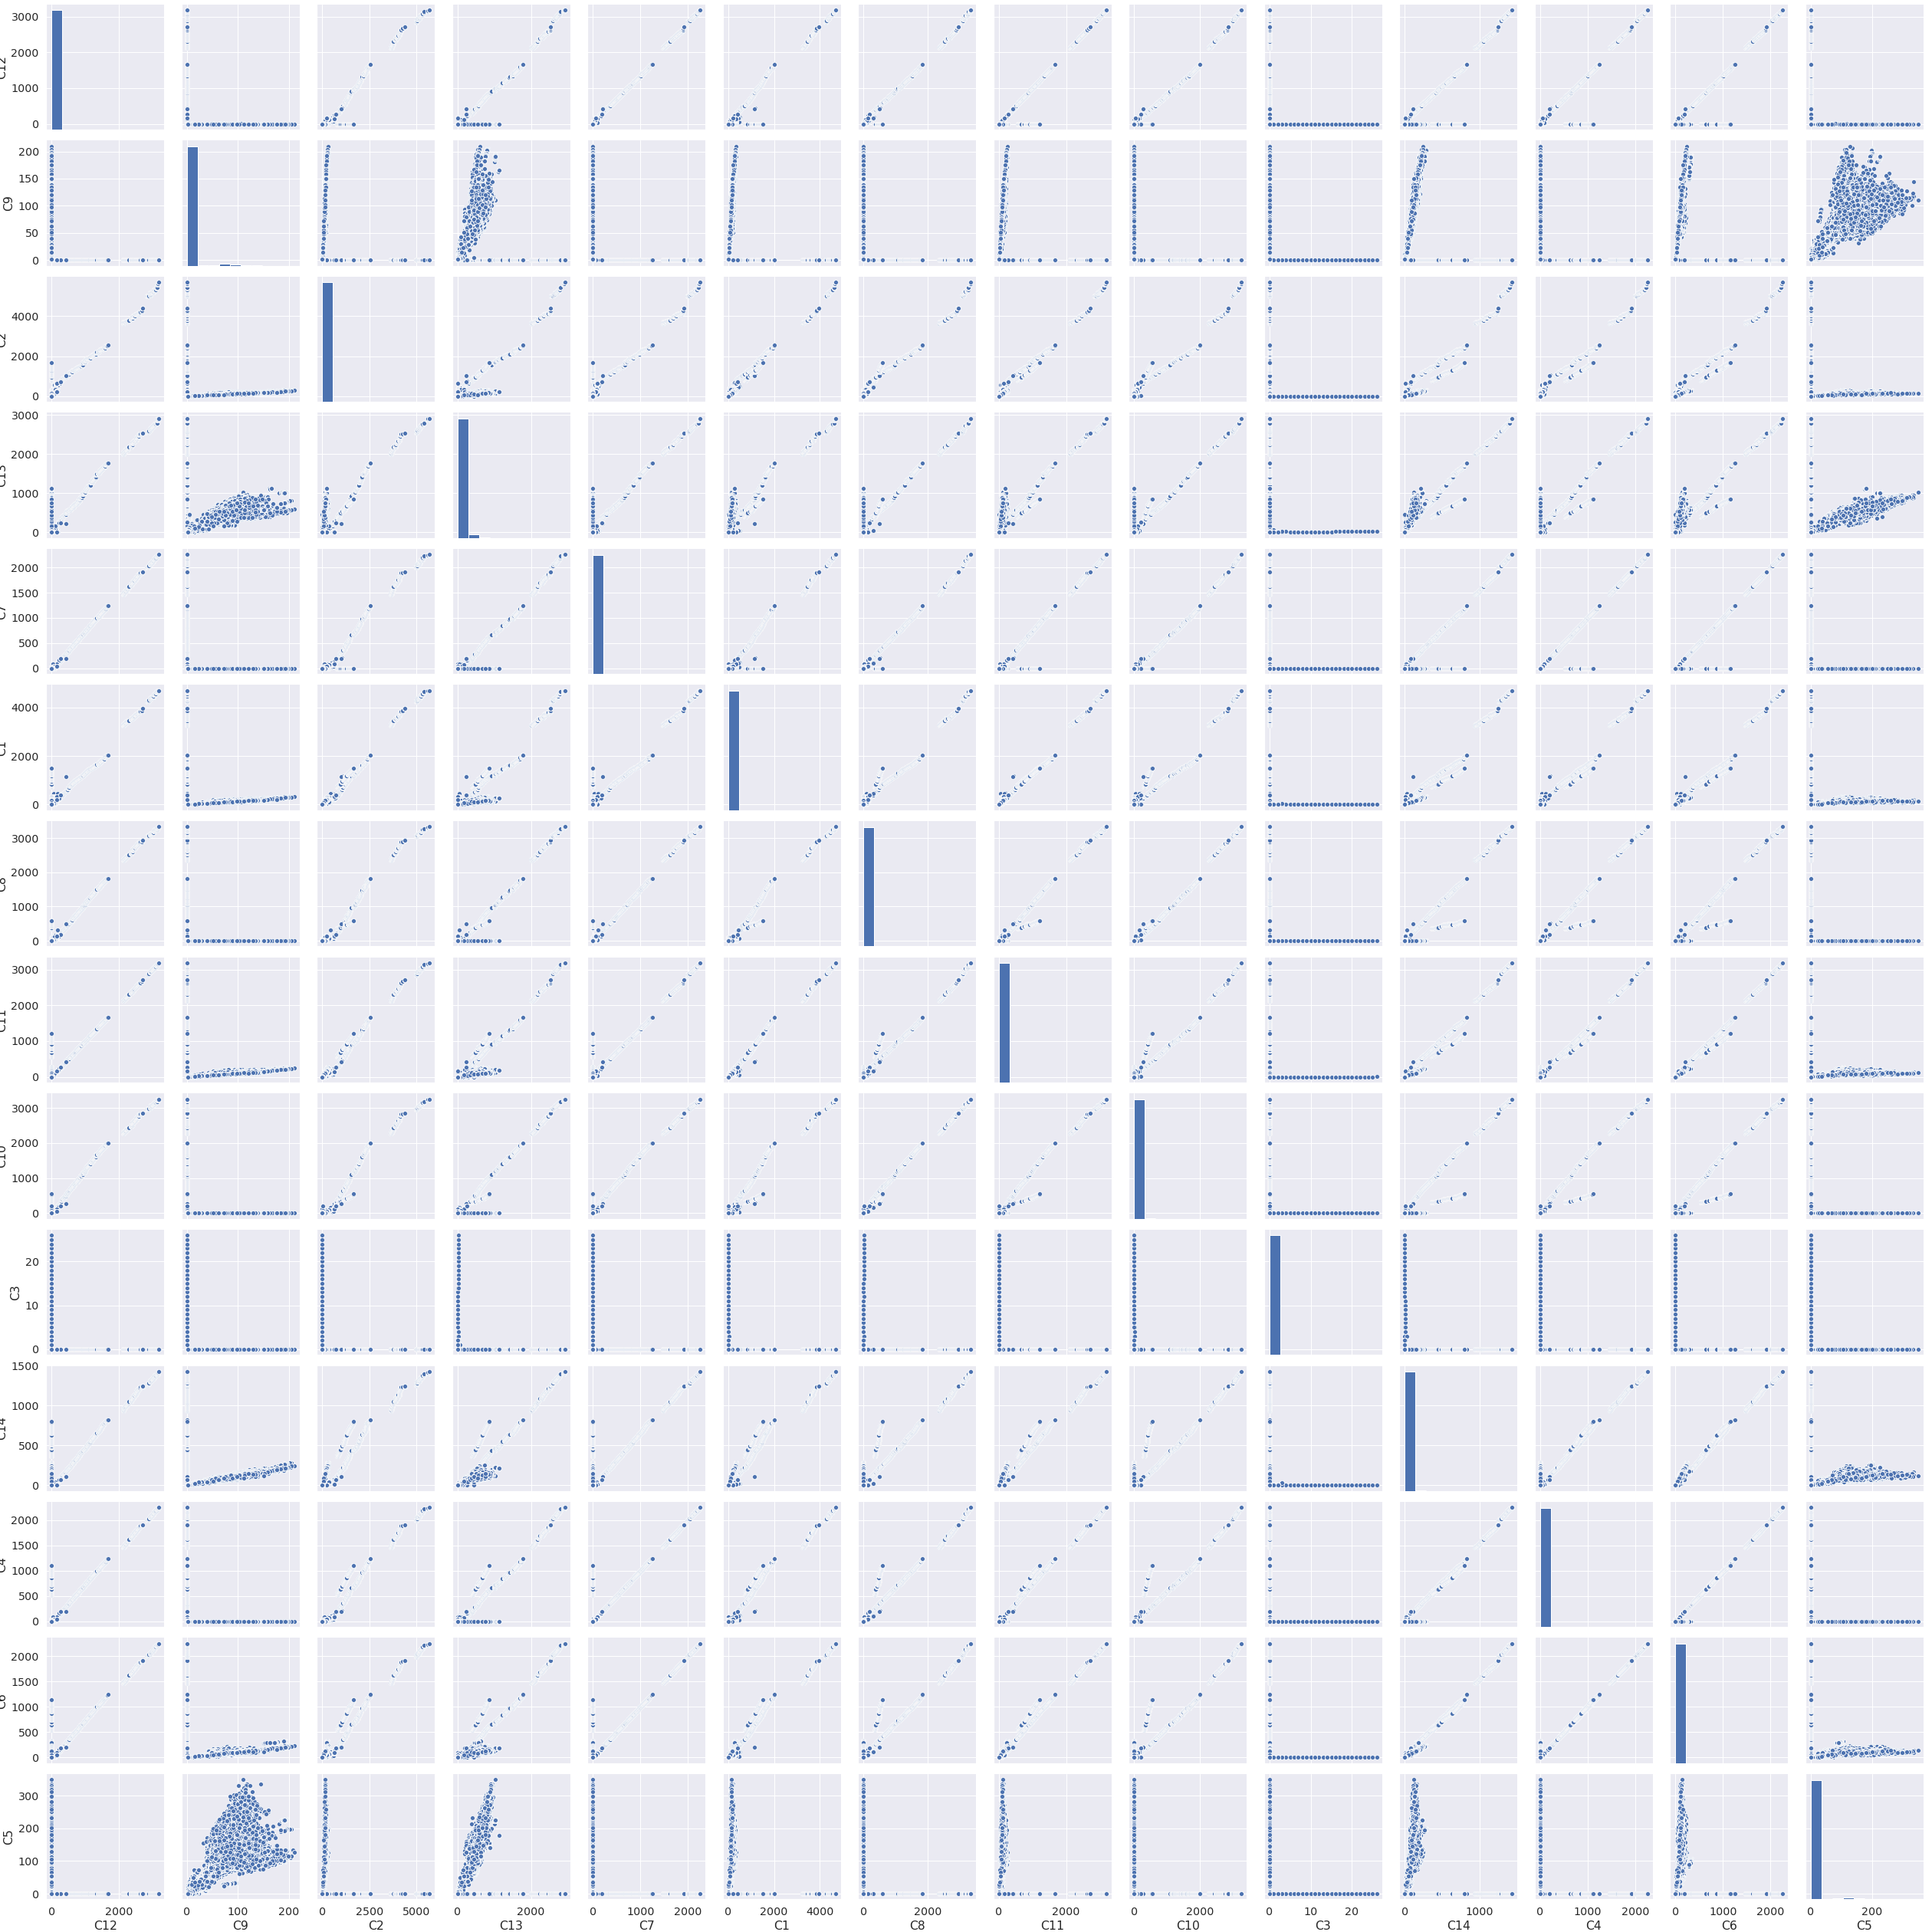

In [48]:
Image( filename ='C_pair_non_nan.png')

In [49]:
cs=list(set(numerical).intersection(set(list(train.filter(regex='C')))))
for c in cs:
  print(c)
  print(train[c].nunique())
  print()

C7
1103

C13
1597

C10
1231

C1
1657

C5
319

C6
1328

C12
1199

C9
205

C11
1476

C3
27

C14
1108

C4
1260

C2
1216

C8
1253



In [50]:
train[cs].describe()

,C7,C13,C10,C1,C5,C6,C12,C9,C11,C3,C14,C4,C2,C8
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,2.848478,32.539918,5.240343,14.092458,5.571526,9.071082,4.076227,4.480240,10.241521,0.005644,8.295215,4.092185,15.269734,5.144574
std,61.727304,129.364844,95.581443,133.569018,25.786976,71.508467,86.666218,16.674897,94.336292,0.150536,49.544262,68.848459,154.668899,95.378574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.000000,12.000000,0.000000,3.000000,1.000000,2.000000,0.000000,2.000000,2.000000,0.000000,2.000000,0.000000,3.000000,0.000000
max,2255.000000,2918.000000,3257.000000,4685.000000,349.000000,2253.000000,3188.000000,210.000000,3188.000000,26.000000,1429.000000,2253.000000,5691.000000,3331.000000


Most has high std,mean and max value except for C3

Lets plot the cs with days

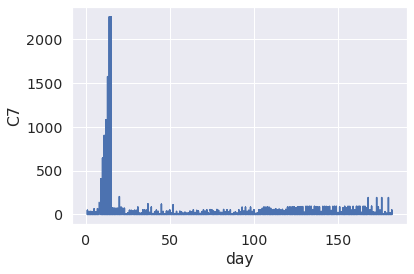

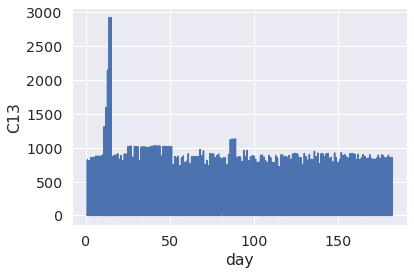

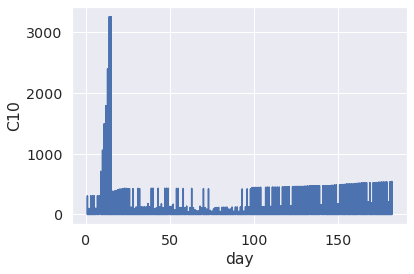

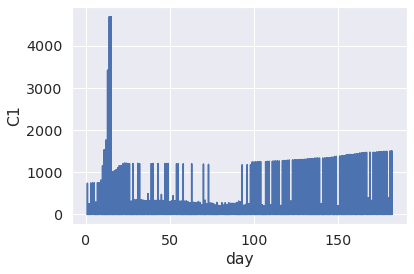

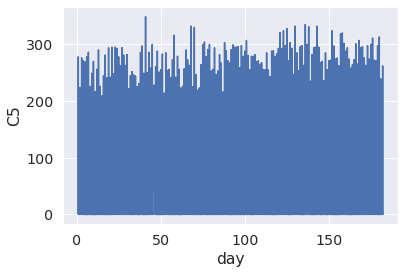

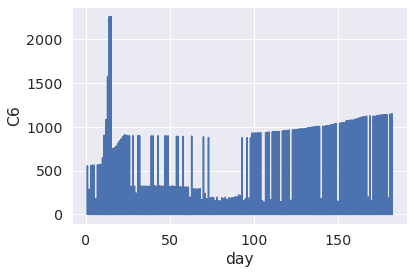

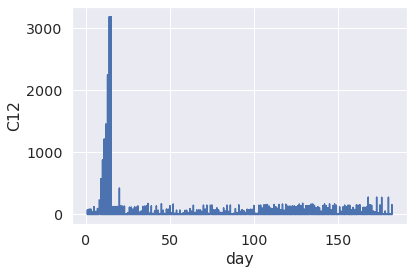

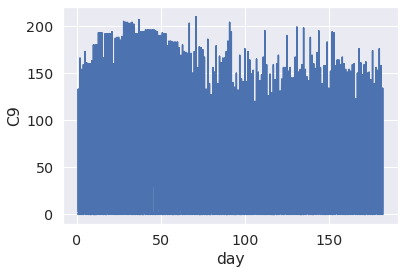

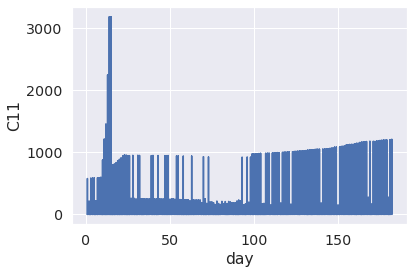

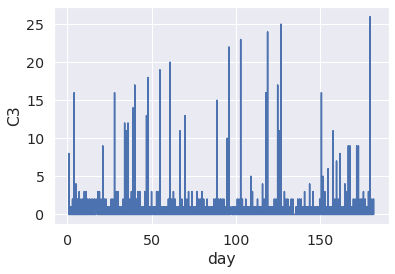

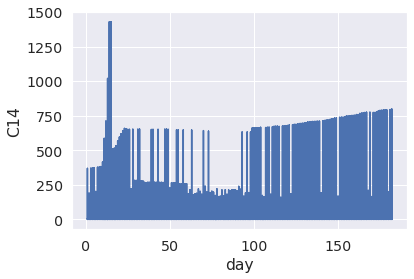

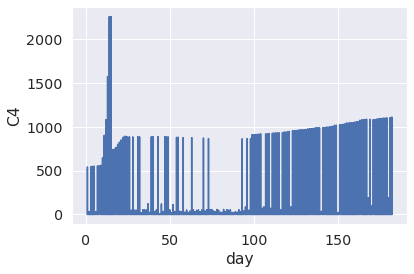

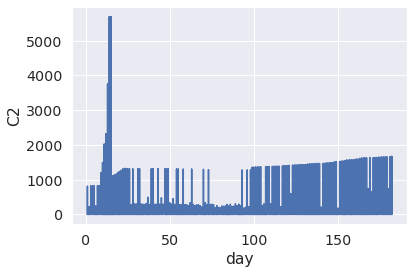

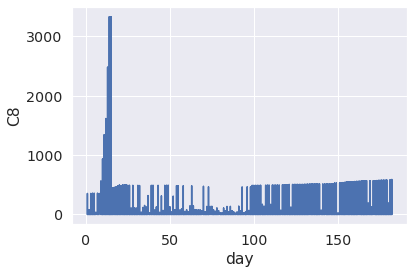

In [51]:
for c in cs:
  plt.plot(train['day'],train[c])
  plt.xlabel('day')
  plt.ylabel(c)
  plt.show()

It seems these are individual count plots. Interesting features could be individual change in cs across transactions

Fill Cs with -999

In [52]:
train[numerical].filter(regex='C').fillna(-999,inplace=True)
test[numerical].filter(regex='C').fillna(-999,inplace=True)

In [53]:
for col in numerical:
  train[col]=train[col].fillna(train[col].mean())
  test[col]=test[col].fillna(test[col].mean())

In [54]:
for i in [1,2,3,4,5,10,11,15]:
  train['d_'+str(i)]=train['day']-train['D'+str(i)]
  test['d_'+str(i)]=test['day']-test['D'+str(i)]

In [55]:
train['id']=''
test['id']=''
for col in ['C1','C13','P_emaildomain','addr1','card1','d_1']:
  train['id']+=train[col].astype(str)
  test['id']+=test[col].astype(str)

In [56]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [57]:
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)
ids=[]
for pd in ['day','month']:
  for col in (numerical):
    ids.extend([col+'_'+pd+'_id'+'_mean',col+'_'+pd+'_id'+'_std'])
    train[col+'_'+pd+'_id'+'_mean']=train.groupby([pd,col])[col].transform('mean')
    train[col+'_'+pd+'_id'+'_std']=train.groupby([pd,col])[col].transform('std')
    test[col+'_'+pd+'_id'+'_mean']=test.groupby([pd,col])[col].transform('mean')
    test[col+'_'+pd+'_id'+'_std']=test.groupby([pd,col])[col].transform('std')

Memory usage of dataframe is 1286.31 MB
Memory usage after optimization is: 688.17 MB
Decreased by 46.5%
Memory usage of dataframe is 1099.80 MB
Memory usage after optimization is: 596.81 MB
Decreased by 45.7%


Drop categorical columns and select only numerical and dummies 

In [67]:
train=train.drop(categorical,1)
test=test.drop(categorical,1)
ids.remove('addr2_day_id_unique')
cols=new_cols+numerical+ids
train=train[cols]
test=test[cols]
gc.collect()

1393

In [72]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)
train.to_csv(F"/content/gdrive/My Drive/fraud/train.csv")
test.to_csv(F"/content/gdrive/My Drive/fraud/test.csv")

Memory usage of dataframe is 1376.98 MB
Memory usage after optimization is: 1376.98 MB
Decreased by 0.0%
Memory usage of dataframe is 1236.56 MB
Memory usage after optimization is: 1193.07 MB
Decreased by 3.5%


**Takeaway points**
1. Included columns with less than 75 percent nanas
2. Got indicator for nan columns
3. Split emaildomain after the '.'
4. Since most of fraud came from nan of Ms got a columns for counting number of nans for a transaction
5. For each categorical columns got dummies of top 10 most frequent value 
6. D1 seemed to represent difference in date from a particular date unique for each user 
7. D3 is difference in days between consecutive transactions
8. V307 is cumulative TransactionAmt
9. Since D columns were difference in days created columns by subtracting from days
10. Filled nan of conitnuous columns by mean and for categorical columns by 'Other'
11. Created mean and standard deviation columns for each individual and time period